In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display #lets you show more than one df
import os
import multiprocessing as mp


In [2]:
# download the data in one of the following ways
# prof link https://drive.google.com/file/d/120_l93SjQE4WDgvjdDB5HyJfh41ygeFg/view
# jakes wget command wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=120_l93SjQE4WDgvjdDB5HyJfh41ygeFg' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=120_l93SjQE4WDgvjdDB5HyJfh41ygeFg" -O tau_data.tgz && rm -rf /tmp/cookies.txt
# ask daniel or jake about getting it off the cloud veneto volume


#configure this string as the directory to where you have the file.
dataDir = '~/LCPB/data/'


#in branch clash test

## Data Structure

#### Folder set 1, f_MT: accretion efficiency (the fraction of mass lost from a primary star that can be accreted by a secondary star during a mass transfer episode).

In [3]:
f_MT= [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9,
0.95, 1]
#create same label as data
f_MT_lb = [str(x).replace('.', '') for x in f_MT]# lb for label

#### Sub folder, Alpha: common envelope efficiency

In [4]:
alpha = [0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
alpha_lb = [str(x) for x in alpha]

#### Files, split by  
data_BHBs_$*$.txt → files corresponding to binary black holes (BHBs)  
data_BHNS_$*$.txt → files corresponding to black hole – neutron star binaries 

$*$ indicates 12 different metallicities (Z) of the stellar progenitors of the binary compact objects.


In [5]:
#Metalicity
Z = [0.0002, 0.0004, 0.0008, 0.0012, 0.0016, 0.002, 0.004, 0.006, 0.008, 0.012, 0.016, 0.02]
Z_lb = [str(x) for x in Z]

#### Data 

* Column 0: identifier of the binary  
* Column 1: initial mass (ZAMS mass) of the primary member of the binary system in Msun (1 Msun= 1.989e33 g). This is the initial mass of the most massive stellar progenitor.  
* Column 2: initial mass (ZAMS mass) of the secondary member of the binarysystem in Msun. This is the initial mass of the least massive stellar progenitor.    
* Column 3: mass of the compact object that forms from the primary member
(Msun)  
* Column 4: mass of the compact object that forms from the secondary member
(Msun)  
* Column 5: mass of the merger remnant of the two compact objects (Msun). In these simulations, it is just the sum of the masses of the two compact objects.
* Column 6: delay time, i.e. time elapsed from the formation of the binary system to the merger of the two compact objects (in Gyr = 1e9 yr)
* Column 7: semi-major axis of the binary system at the formation of the second-born compact object (in solar radii, Rsun = 6.96e10 cm)
* Column 8: orbital eccentricity of the binary system at the formation of the second-born compact object.

In [6]:

# get data is a tool for extracting a dataframe of desired information out of the data files

# col is an list of indexes that corrspond to the columb numbers of the data in each file.
# only the columbs specified with this will be read and returned

# fmt_index,alpha_index and Z_index are list of indexes for the simulation parameters. eg fmt_index = [0,3] 
# corresponds to 0.05 and 0.2 of the lists vreated above. 
# fmt_index = 'all' means the entire range is inserted for the index.
# only binary black holes in the files specified by the indexes are placed in the final dataframe. 

# fmt_inc, alpha_inc and Z_inc are boolean variables. When true the data frame will also have a column for these values

#get_all, when true makes a dataframe with all of the binary black hole data. Only to be used if you have a good system.

# function to get the data frame given the file name and columns desired. fmt alpha and Z are required becaue the values are different to what is expressed in the file name
# it is used in getData and required to be a global function to be used by paralellisation.
def getDF(file_name, columb_numbers, fmt, alpha, Z, fmt_inc, alpha_inc, Z_inc, head):
    df = pd.DataFrame(columns=head)
    try:
        df=pd.read_csv(file_name, sep=" ", skiprows=[0],header=None, usecols = columb_numbers)

        if (fmt_inc):
            df["f_MT"] = fmt
        if (alpha_inc):
            df["alpha"] = alpha
        if (Z_inc):
            df["Z"] = Z
        #rename header of df
        df.columns = head    
    except:
        if (Z!=0.02):
            print(file_name+": Does not exist, this means no simulation was done with these parameters")
    
    return df


def getData(col = [0],fmt_index = [0], fmt_inc = False, alpha_index = [0], alpha_inc = False, 
            Z_index = [0], Z_inc = False, get_all = False, n_jobs = 1, v = False):
    variables = locals()
    head_map = {'0':'id','1':'init_mass_prim','2':'init_mass_sec','3':'comp_mass_prim','4':'comp_mass_sec','5':'merger_mass','6':'delay_time','7':'semi_maj_axis','8':'orb_esc'}
    
    if (get_all):
        variables['col'] = 'all'
        variables['fmt_index'] = 'all'
        variables['fmt_inc'] = True
        variables['alpha_index'] = 'all'
        variables['alpha_inc'] = True
        variables['Z_index'] = 'all'
        variables['Z_inc'] = True
        variables['get_all'] = False
        return getData(**variables)
    
    if fmt_index == 'all':
        fmt_index = range(0,20)
    if alpha_index == 'all':
        alpha_index = range(0,11)
    if Z_index == 'all':
        Z_index = range(0,12)
    if col == 'all':
        col = [0,1,2,3,4,5,7,8]
    
    
    getData_num_files = len(fmt_index) * len(alpha_index) * len(Z_index)
    
    #make reduced versions of variable lists, so we only get what we want
    f_MT_lb_red = [f_MT_lb[ind] for ind in fmt_index]
    f_MT_red = [f_MT[ind] for ind in fmt_index]
    alpha_lb_red = [alpha_lb[ind] for ind in alpha_index]
    alpha_red = [alpha[ind] for ind in alpha_index]
    Z_lb_red = [Z_lb[ind] for ind in Z_index]
    Z_red = [Z[ind] for ind in Z_index]
    
    # make list of columns we want, also make header of df
    # 6 is the time delay
    columb_numbers = [*col,6]
    head = [str(x) for x in columb_numbers]
    head = [head_map[x] for x in head]
    if (fmt_inc):
        head = [*head,'acr_eff']
    if (alpha_inc):
        head = [*head,'ce_eff']
    if (Z_inc):
        head = [*head,'metalicity']
    
    #make list of getDF args dictionaries
    getDF_args = []
    for f_i in range(len(fmt_index)):
        for a_i in range(len(alpha_index)):
            for Z_i in range(len(Z_index)):
                file_name = dataDir+"vnew_delayed_fMT"+ f_MT_lb_red[f_i] + "/A"+ alpha_lb_red[a_i] +"/data_BHBs_"+Z_lb_red[Z_i]+".txt"
                getDF_arg = {'file_name':file_name,'columb_numbers':columb_numbers,'fmt':f_MT_red[f_i],'alpha':alpha_red[a_i],'Z':Z_red[Z_i],'fmt_inc':fmt_inc,'alpha_inc':alpha_inc,'Z_inc':Z_inc,'head':head}
                getDF_args.append(getDF_arg)
                
                #code jake used to get first row info from file
                #hd=pd.read_csv(file_name, nrows = 1, sep = " ", header = None)
                #hd.columns=['m_itotal_stellar','N_bin_compact_mergers']
    

    #paralellisation conditions
    if(getData_num_files == 1):
            print('there is only 1 file, so there is no paralellisation')
    if (n_jobs > 1):
        if(n_jobs > os.cpu_count()): 
            print("you have entered more jobs than you have cores, jobs set to number of system cores")
            n_jobs = os.cpu_count()
        elif(getData_num_files < n_jobs): 
            print('You have entered more jobs than files you have requested. n_jobs reduced to number of files')
            n_jobs = getData_num_files
        else: #do paralellisation
            pool = mp.Pool(n_jobs)
            df_list = pool.starmap(getDF, [list(getDF_arg.values()) for getDF_arg in getDF_args])
            pool.close()
            
            df_conc = pd.DataFrame(columns=head)
            for df_i in df_list:
                df_conc = pd.concat([df_conc,df_i])                
            
            return df_conc
    else:# no paralellisation
        percentage = 1
        files_done = 0
        df_conc = pd.DataFrame(columns=head)
        for getDF_arg in getDF_args:
            #get the data frame for one file name in the set of getDF arguments
            df = getDF(**getDF_arg)
            #concatonate data frame
            df_conc = pd.concat([df_conc,df])
            files_done += 1
            if (v):
                if(files_done >= percentage*(getData_num_files/10)):
                    percentage += 1
                    print('percentage complete: ',int(files_done*100/getData_num_files),'%')
        
        return df_conc


#plot median takes a dataframe with one of the simulation parameters and time_delay and 
# used group by to make a median time_delay plot as a function of the parameter value.
# it also returns the resulting dataframe for further analysis. 
def plotMedian(df,prop):
    def lowerQuartile(stuff):
        return np.quantile(stuff,0.25)
    def upperQuartile(stuff):
        return np.quantile(stuff,0.75)

    med = df.groupby(prop)['time_delay'].agg('median').reset_index()
    lq = df.groupby(prop)['time_delay'].agg(lowerQuartile).reset_index()
    uq = df.groupby(prop)['time_delay'].agg(upperQuartile).reset_index()
    med.columns = [prop, 'median_time_delay']

    med['lower_quartile'] = lq['time_delay']
    med['upper_quartile'] = uq['time_delay']
    figAcc = plt.figure()
    plt.plot(med[prop],med['median_time_delay'],label = 'Median')
    plt.xlabel(prop)
    plt.ylabel('Time Delay')
    plt.title('Binary Black Hole Systems')
    plt.fill_between(med[prop], med['lower_quartile'], med['upper_quartile'], alpha=0.4, color='darkorange',label = 'Interquartile Range')
    plt.legend()
    return med


In [11]:
# paralellisation test
%timeit getData(fmt_index = 'all',n_jobs = 7)
%timeit getData(fmt_index = 'all',n_jobs = 1)

745 ms ± 26.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.33 s ± 1.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
getData()

there is only 1 file, so there is no paralellisation


,id,delay_time
0,1,0.008093
1,5,0.010175
2,9,0.272228
3,10,0.008453
4,11,0.04459
...,...,...
9425,4469,1.133371
9426,4470,0.720805
9427,4472,0.107169
9428,4474,0.007961


# Accretion Efficiancy

In [ ]:
# Accretion Efficiency f_MT, getting the data
df = getData(fmt_inc = True, fmt_index = 'all',alpha_index = 'all', Z_index = 'all',n_jobs = 7)
df.columns = ['time_delay','id','Accretion Efficiency']
median = plotMedian(df,'Accretion Efficiency')
median

# Common Envalope Efficiancy

,Common Envalope Efficiancy,median_time_delay,lower_quartile,upper_quartile
0,0.5,2226.0,1094.00,3315.75
1,1.0,5900.0,2932.00,8891.00
2,2.0,12909.0,6468.00,19283.00
3,3.0,18757.0,9452.75,28055.50
4,4.0,20408.0,10190.00,30504.00
5,5.0,20304.0,10246.00,30445.00
6,6.0,19231.0,9586.75,28945.25
7,7.0,17680.5,8881.25,26507.75
8,8.0,15620.5,7903.75,23403.00
9,9.0,13308.0,6672.00,20019.00


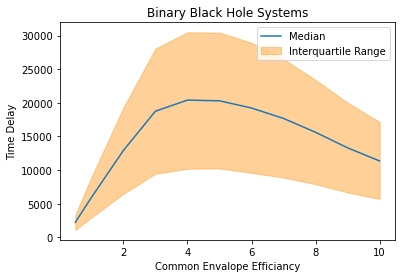

In [23]:
df = getData(alpha_inc = 'True',alpha_index = 'all')
df.columns = ['time_delay','id','Common Envalope Efficiancy']

median = plotMedian(df,'Common Envalope Efficiancy')
median

# Metalicity

,Metalicity,median_time_delay,lower_quartile,upper_quartile
0,0.0002,5971.0,2970.25,8909.75
1,0.0004,5847.0,2902.75,8769.00
2,0.0008,5319.0,2664.00,7965.00
3,0.0012,5130.0,2557.00,7675.50
4,0.0016,5133.0,2585.00,7646.00
5,0.0020,5354.0,2640.00,8021.75
6,0.0040,10942.0,5467.00,16423.25
7,0.0060,6414.0,3229.00,9563.00
8,0.0080,5219.0,2600.25,7819.75
9,0.0120,3855.0,2107.50,5607.00


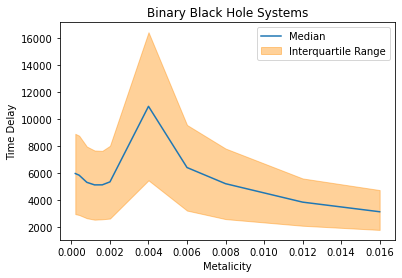

In [14]:
df = getData(Z_inc = True, Z_index = 'all')
df.columns = ['time_delay','id','Metalicity']
plotMedian(df,'Metalicity')